<a href="https://www.kaggle.com/code/zrosen3/housing-prices-rosen?scriptVersionId=101187150" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Initial data exploration

Load in packages.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns #for graphs
import matplotlib.pyplot as plt  #for graphs
from scipy.stats import chi2_contingency  #for performing chi squared test
from sklearn.feature_selection import VarianceThreshold #to split variables into differnet groups
from sklearn import preprocessing #for variale encoding
import copy #for copying variables 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier #for random forest models
from sklearn.metrics import mean_absolute_error #for evaluating model performance
from sklearn.linear_model import LinearRegression #for linear regression
from sklearn.model_selection import cross_val_score #for cross validating model performance
import statistics as stat #for calculating standard deviations





# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


Load in data

In [2]:
#description = pd.read_txt("../input/house-prices-advanced-regression-techniques/data_description.txt")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
sample = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")

View each dataframe

In [3]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
sample.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


Look at distribution of sales price, our target variable. 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


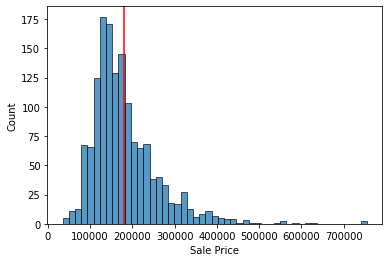

In [6]:
sns.histplot(
    train["SalePrice"]
).set(xlabel = 'Sale Price', ylabel = 'Count')
plt.axvline(x = train["SalePrice"].mean(), color = "red")
print(train['SalePrice'].describe())

Sale price seems to have a right skew, with most prices between $100,000-$300,000 and a few high outliers.

Normalize sale price since it is right skewed.

In [7]:
mean_price = train["SalePrice"].mean()
std_price = stat.stdev(train["SalePrice"])
train["SalePrice"] = (train["SalePrice"] - mean_price)/std_price

# Investigate missing values.

In [8]:
missing_variables = train[train.columns[train.isnull().any()]]
missing_variables.isnull().sum()
missing_variables.dtypes

LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
dtype: object

Drop variables with over half missing values.

In [9]:
train = train.dropna(axis=1, thresh = len(train)/2)
train_cols = [col for col in list(train.columns) if not col == "SalePrice"]
test = test[train_cols]

Fill remaining numeric values with median, categorical with mode

In [10]:
numeric_columns = train.select_dtypes(include = 'number').columns
string_columns = train.select_dtypes(include = 'object').columns
train[numeric_columns] = train[numeric_columns].fillna(train[numeric_columns].median(skipna = True))
train[string_columns] = train[string_columns].fillna(train[string_columns].mode(dropna = True))

numeric_columns = test.select_dtypes(include = 'number').columns
string_columns = test.select_dtypes(include = 'object').columns
test[numeric_columns] = test[numeric_columns].fillna(test[numeric_columns].median(skipna = True))
test[string_columns] = test[string_columns].fillna(test[string_columns].mode(dropna = True))



# Categorical variable exploration

Now, we've found the numeric variables we want to include in our model. Let's take a look at the categorical variables to see which ones seem to impact sale price.

In [11]:
categorical_data = train.select_dtypes(include = object)
categorical_data.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


I will create a series of count plots to get a sense of the distribution of these categorical variables.

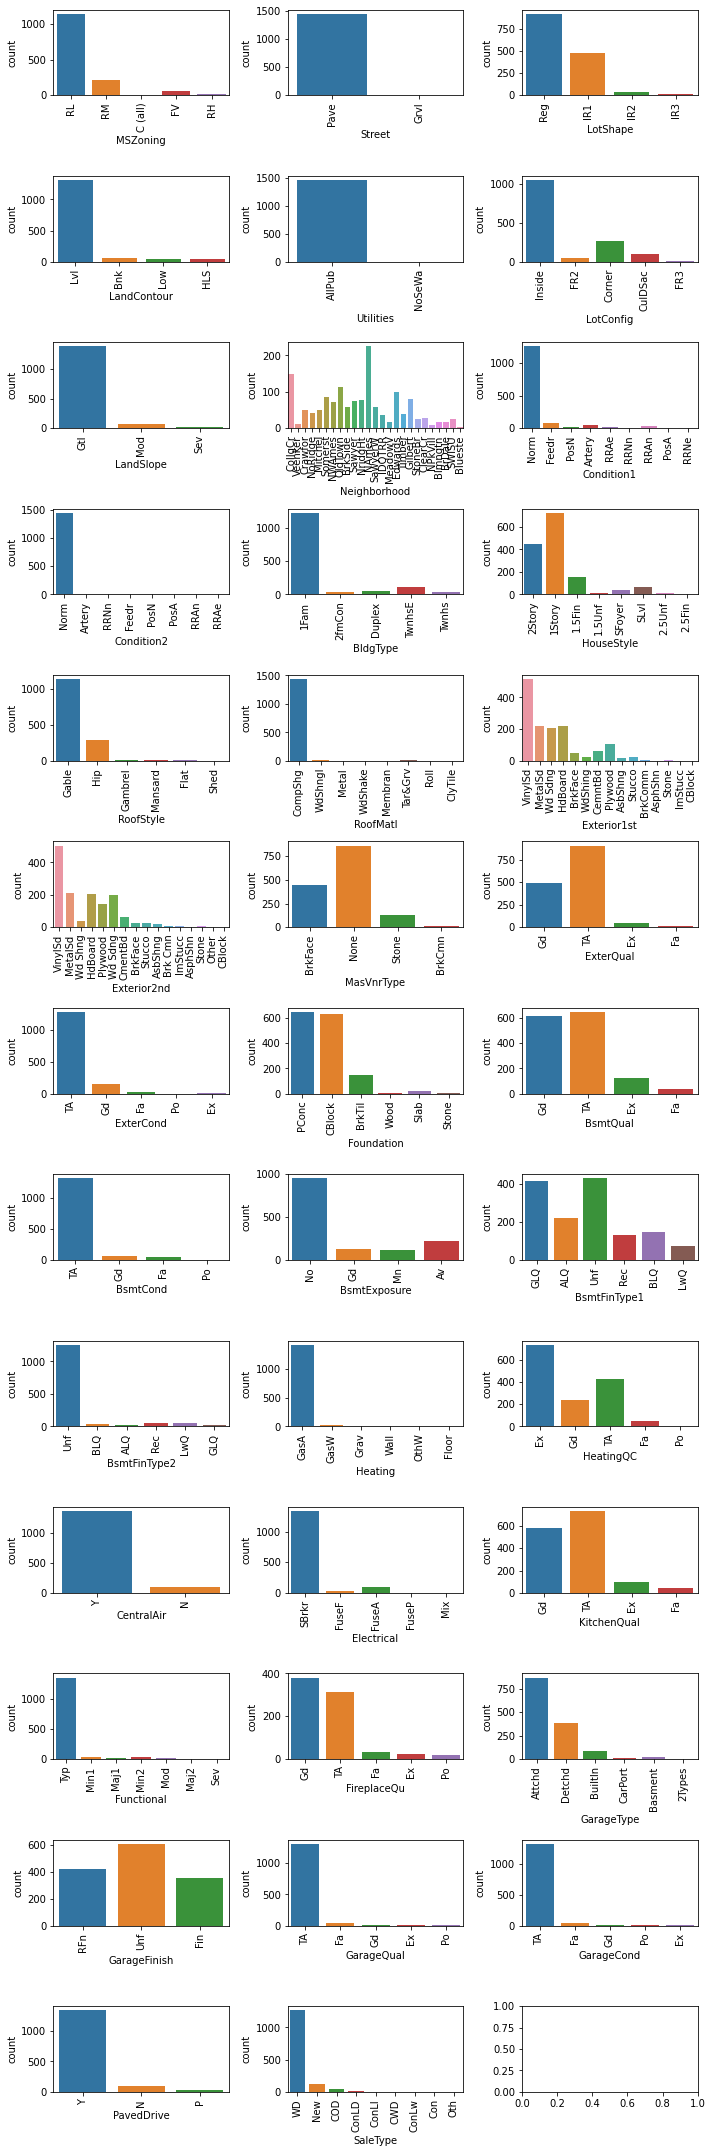

In [12]:
fig, axes = plt.subplots(round(len(categorical_data.columns)/3),3, figsize = (10, 30))
for i, ax in enumerate(fig.axes):
    if i < len(categorical_data.columns)-1:
        sns.countplot(x = categorical_data.columns[i], ax = ax, data = categorical_data)
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
fig.tight_layout()



Look at distribution of sale price within categorical variables. 

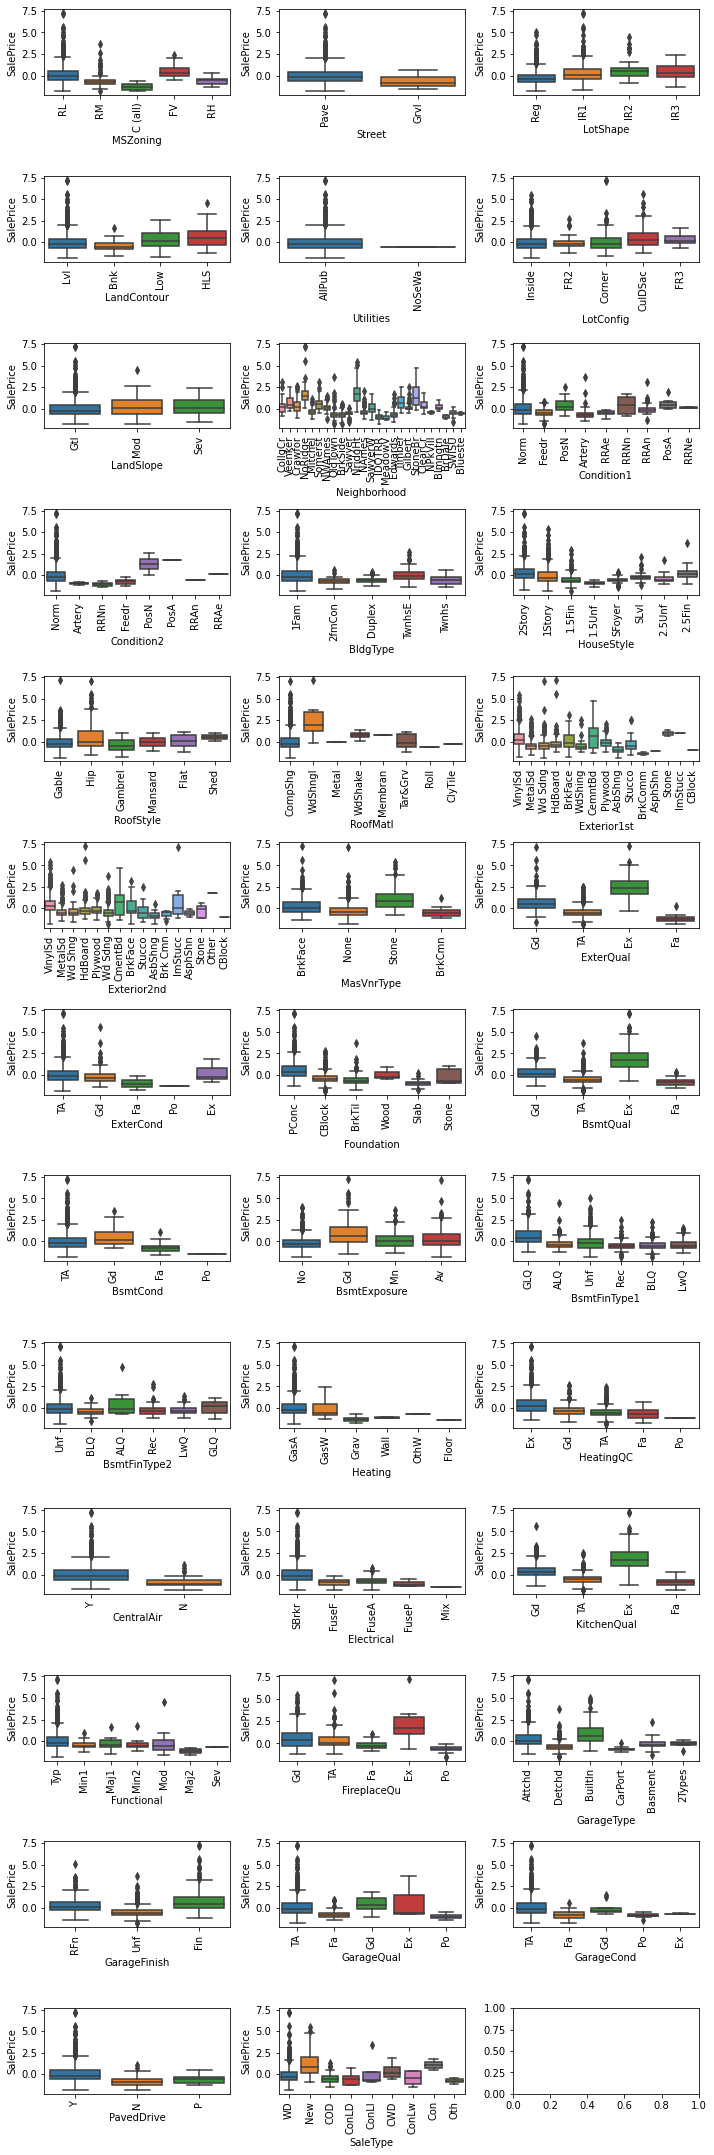

In [13]:
fig, axes = plt.subplots(round(len(categorical_data.columns)/3),3, figsize = (10, 30))
for i, ax in enumerate(fig.axes):
    if i < len(categorical_data.columns)-1:
        sns.boxplot(x = train[categorical_data.columns[i]], ax = ax, y = train["SalePrice"])
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
fig.tight_layout()



From looking at the boxplots, there are several variables which do not appear to affect price significantly Before dropping any of these variables, let's convert categorical data to numeric to get a sense of correlation with sale price.

In [14]:
label_encoder = preprocessing.LabelEncoder()
categorical_data = categorical_data.apply(label_encoder.fit_transform)
train[list(categorical_data.columns)] = train[list(categorical_data.columns)].apply(label_encoder.fit_transform)
test[list(categorical_data.columns)] = test[list(categorical_data.columns)].apply(label_encoder.fit_transform)


# Choosing numeric variables

Use feature engineering to create variables for total square footage and and number of bathrooms.

In [15]:
#square footage
train['TotalSF'] = train["TotalBsmtSF"] + train["1stFlrSF"] + train["2ndFlrSF"] + train["GrLivArea"]
test['TotalSF'] = test["TotalBsmtSF"] + test["1stFlrSF"] + test["2ndFlrSF"] + test["GrLivArea"]


#number of bathrooms
train["TotalBath"] = train["FullBath"] + 0.5 * train["HalfBath"] + train["BsmtFullBath"] + 0.5 * train["BsmtHalfBath"]
test["TotalBath"] = test["FullBath"] + 0.5 * test["HalfBath"] + test["BsmtFullBath"] + 0.5 * test["BsmtHalfBath"]

Drop columns captured by new variables.

In [16]:
#drop columns captured in new variables
train.drop(["TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea"], axis = 1, inplace = True)
train.drop(["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"], axis = 1, inplace = True )
test.drop(["TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea"], axis = 1, inplace = True)
test.drop(["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"], axis = 1, inplace = True)

Look at numerical values, try to see which ones are correlated with housing prices. If not correlated, then drop variable. Note that ID will not be treated as numeric.

In [17]:
numeric_columns = train.select_dtypes(include = np.number)
numeric_columns = numeric_columns.drop("Id", axis = 1)
numeric_columns

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF,TotalBath
0,60,3,65.0,8450,1,3,3,0,4,0,...,0,0,0,2,2008,8,4,0.347154,4276,3.5
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,5,2007,8,4,0.007286,3786,2.5
2,60,3,68.0,11250,1,0,3,0,4,0,...,0,0,0,9,2008,8,4,0.535970,4492,3.5
3,70,3,60.0,9550,1,0,3,0,0,0,...,0,0,0,2,2006,8,0,-0.515105,4190,2.0
4,60,3,84.0,14260,1,0,3,0,2,0,...,0,0,0,12,2008,8,4,0.869545,5541,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,3,62.0,7917,1,3,3,0,4,0,...,0,0,0,8,2007,8,4,-0.074534,4247,2.5
1456,20,3,85.0,13175,1,3,3,0,4,0,...,0,0,0,2,2010,8,4,0.366036,5688,3.0
1457,70,3,66.0,9042,1,3,3,0,4,0,...,0,0,2500,5,2010,8,4,1.077242,5832,2.0
1458,20,3,68.0,9717,1,3,3,0,4,0,...,0,0,0,4,2010,8,4,-0.488356,3234,2.0


I will draw a bunch of histograms to get a sense ot the distribution of these numeric variables. 

array([[<AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'MSZoning'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'Street'}>,
        <AxesSubplot:title={'center':'LotShape'}>,
        <AxesSubplot:title={'center':'LandContour'}>,
        <AxesSubplot:title={'center':'Utilities'}>],
       [<AxesSubplot:title={'center':'LotConfig'}>,
        <AxesSubplot:title={'center':'LandSlope'}>,
        <AxesSubplot:title={'center':'Neighborhood'}>,
        <AxesSubplot:title={'center':'Condition1'}>,
        <AxesSubplot:title={'center':'Condition2'}>,
        <AxesSubplot:title={'center':'BldgType'}>,
        <AxesSubplot:title={'center':'HouseStyle'}>,
        <AxesSubplot:title={'center':'OverallQual'}>],
       [<AxesSubplot:title={'center':'OverallCond'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,


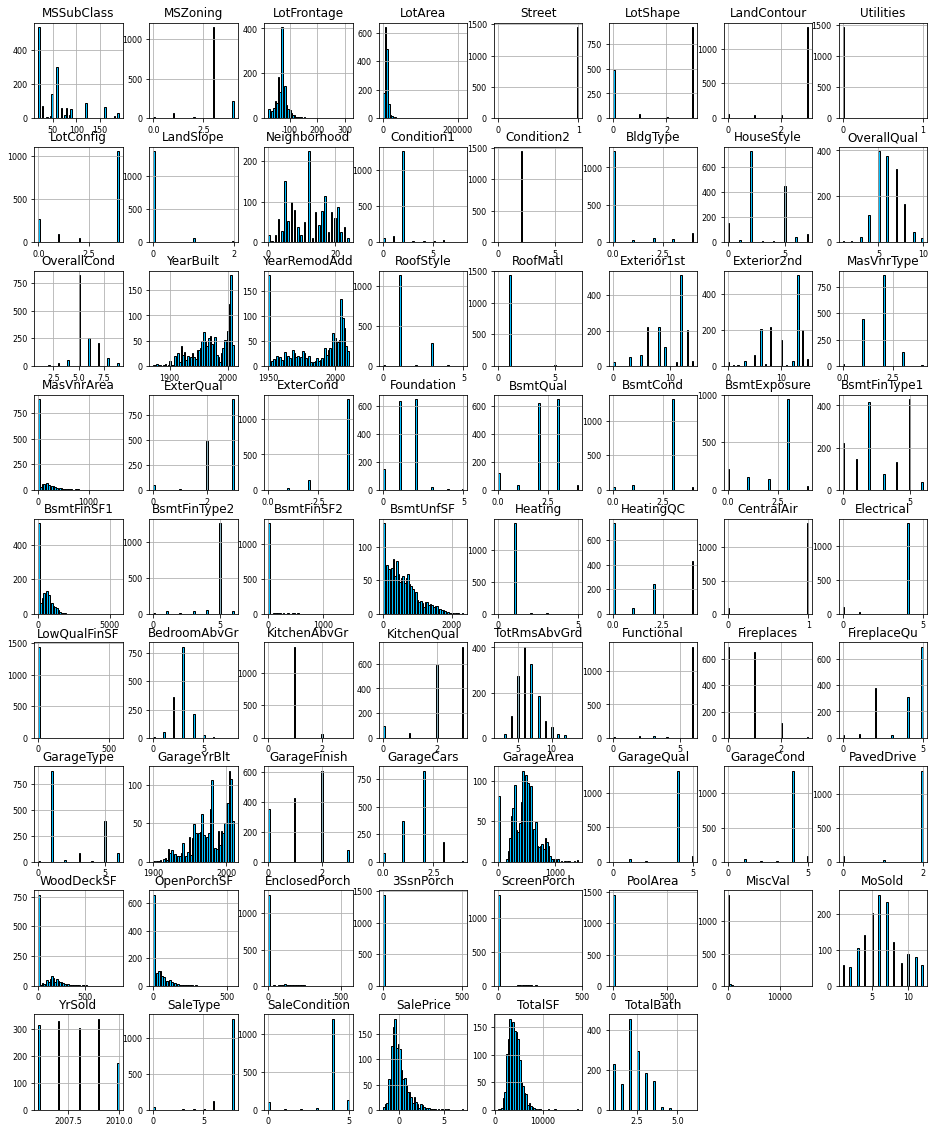

In [18]:
numeric_columns.hist(figsize = (16, 20), bins = 50, color = "deepskyblue", edgecolor = "black", xlabelsize =8, ylabelsize = 8)

Look at each variable's correlation with sale price.

In [19]:
corr_matrix=numeric_columns.corr()
print(corr_matrix["SalePrice"].sort_values(ascending=False))


SalePrice       1.000000
OverallQual     0.790982
TotalSF         0.777123
GarageCars      0.640409
TotalBath       0.631731
                  ...   
FireplaceQu    -0.459969
GarageFinish   -0.549247
KitchenQual    -0.589189
BsmtQual       -0.620886
ExterQual      -0.636884
Name: SalePrice, Length: 70, dtype: float64


Only select highly correlated features.

In [20]:
cut_off = 0.5
cor_values = abs(corr_matrix["SalePrice"])
relevant_numerics = cor_values[cor_values > cut_off]
relevant_numerics.sort_values(ascending = False)


SalePrice       1.000000
OverallQual     0.790982
TotalSF         0.777123
GarageCars      0.640409
ExterQual       0.636884
TotalBath       0.631731
GarageArea      0.623431
BsmtQual        0.620886
KitchenQual     0.589189
GarageFinish    0.549247
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

Now we have values highly correlated with saleprice. Let's filter to these highly correlated variables and create a correlation matrix to check if independent variables are uncorrelated.

<AxesSubplot:>

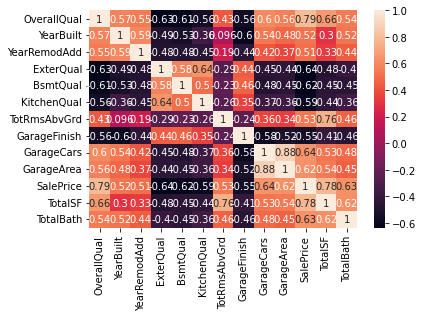

In [21]:
numeric_columns = numeric_columns[list(relevant_numerics.index)]
corr_matrix=numeric_columns.corr()
sns.heatmap(corr_matrix, annot = True)


There seems to be a few numeric variables that are highly correlated with one another. OverallQual is highly correlated with SalePrice, which is not an issue since SalePrice is our target variable. 

GarageCars and GarageArea have a correlation of 0.88. The garage correlation seems most troubling, and intuitively these variables shouldn't contain much different information. Let's drop garage cars.

In [22]:
numeric_columns = numeric_columns.drop("GarageCars", axis = 1)

# Modelling

Select variables for model, prepare dataframes for input.

In [23]:
features = [col for col in list(numeric_columns) if not col == "SalePrice"]
X = train[features]
X_test = test[features]
y = train["SalePrice"]


Run linear regression model

In [24]:
linear_model = LinearRegression()
linear_model.fit(X, y)
predictions_linear = linear_model.predict(X_test)

In [25]:
r_squared = linear_model.score(X, y)
print(f"R squared: {r_squared}")
print(f"Coefficients: {linear_model.coef_}")
linear_cv = cross_val_score(linear_model,X, y,cv=5, scoring = "neg_root_mean_squared_error")
print([-score for score in linear_cv])
print(-linear_cv.mean())

R squared: 0.7977177404767759
Coefficients: [ 0.17756391  0.00088624  0.00094401 -0.10299691 -0.10050322 -0.12987792
  0.00226355 -0.04214123  0.00048603  0.00026916  0.10839588]
[0.37280163215814466, 0.45362530927940287, 0.47927253610114146, 0.38281672543747447, 0.5848834352105705]
0.4546799276373468


In [26]:
##submission
output = pd.DataFrame({'Id': test.Id, 'SalePrice': predictions_linear})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
